***Implementation of a Three Hidden Layer Neural Network for Multi-Class Classification***


In this assignment,  a three hidden layer neural network is implented for multi-class classification.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


**Dataset**

A synthetic dataset is created with 2800 samples, 12 features, and 5 classes, normalizes the features, converts labels to one-hot encoding, and splits the data into 80% training and 20% testing sets.

In [11]:

X, y = make_classification(
    n_samples=2800, n_features=12, n_classes=5,
    n_informative=7, n_redundant=0, n_clusters_per_class=1,
    class_sep=1.8, random_state=42
)


X = (X - X.mean(axis=0)) / X.std(axis=0)
Y = np.eye(5)[y]


X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=y, random_state=42
)


**Neural Network Class Definition, Model initialization and Training loop**

The neural network is built from scratch.  instead of a single hidden layer with sigmoid activations,  a deeper multi‑layer architecture is built with three hidden layers using ReLU and a softmax output for multi‑class classification
- Weights & biases are initialized with He initialization for stable training.
- Forward pass: inputs flow through hidden layers with ReLU, final layer uses softmax for class probabilities.
- Loss: cross‑entropy measures prediction error.
- Backward pass: gradients are computed layer by layer and parameters updated with gradient descent.
- Predict: runs forward and picks the class with highest probability.
- Training loop: shuffles data, trains in batches, and prints loss/accuracy every few steps.


In [16]:
# Neural Network Implementation

class CustomNN:
    def __init__(self, input_dim, hidden_dims, output_dim, lr=0.01):
        self.lr = lr
        self.sizes = [input_dim] + hidden_dims + [output_dim]
        L = len(self.sizes) - 1

        self.W = []
        self.b = []
        for i in range(L):
            W_i = np.random.randn(self.sizes[i], self.sizes[i+1]) * np.sqrt(2.0 / self.sizes[i])
            b_i = np.zeros((1, self.sizes[i+1]))
            self.W.append(W_i)
            self.b.append(b_i)

    def relu(self, z): return np.maximum(0, z)
    def relu_derivative(self, z): return (z > 0).astype(float)
    def softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # Forward pass
    def forward(self, X):
        current = X
        pre_layers, post_layers = [], [current]

        #hidden layer
        for i in range(len(self.W) - 1):
            z = np.dot(current, self.W[i]) + self.b[i]
            pre_layers.append(z)
            current = self.relu(z)
            post_layers.append(current)

        # output layer
        z_final = np.dot(current, self.W[-1]) + self.b[-1]
        pre_layers.append(z_final)
        probs = self.softmax(z_final)
        post_layers.append(probs)

        return pre_layers, post_layers

    # Loss function
    def compute_loss(self, probs, Y):
        eps = 1e-12
        losses = -np.sum(Y * np.log(probs + eps), axis=1)
        return np.mean(losses)

    # Backward pass
    def backward(self, pre_layers, post_layers, X_batch, Y_batch):
        N = X_batch.shape[0]
        L = len(self.W)

        grad_W, grad_b = [None] * L, [None] * L
        probs = post_layers[-1]

        # output gradient
        delta = (probs - Y_batch) / N
        grad_W[-1] = np.dot(post_layers[-2].T, delta)
        grad_b[-1] = np.sum(delta, axis=0, keepdims=True)

        # hidden layers
        for i in reversed(range(L-1)):
            relu_mask = self.relu_derivative(pre_layers[i])
            delta = np.dot(delta, self.W[i+1].T) * relu_mask
            grad_W[i] = np.dot(post_layers[i].T, delta)
            grad_b[i] = np.sum(delta, axis=0, keepdims=True)

        # update step
        for i in range(L):
            self.W[i] -= self.lr * grad_W[i]
            self.b[i] -= self.lr * grad_b[i]

    def predict(self, X):
        return np.argmax(self.forward(X)[1][-1], axis=1)


# Training Loop

model = CustomNN(input_dim=12, hidden_dims=[64, 32, 16], output_dim=5, lr=0.01)

epochs = 140
batch_size = 64
n_train = X_train.shape[0]
steps_per_epoch = int(np.ceil(n_train / batch_size))

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    perm = np.random.permutation(n_train)
    X_shuf, Y_shuf = X_train[perm], Y_train[perm]

    epoch_losses = []
    for step in range(steps_per_epoch):
        start, end = step * batch_size, min((step+1) * batch_size, n_train)
        X_batch, Y_batch = X_shuf[start:end], Y_shuf[start:end]

        pre, acts = model.forward(X_batch)
        loss = model.compute_loss(acts[-1], Y_batch)
        epoch_losses.append(loss)

        model.backward(pre, acts, X_batch, Y_batch)

    train_losses.append(np.mean(epoch_losses))
    y_train_pred = model.predict(X_train)
    train_accs.append(accuracy_score(np.argmax(Y_train, axis=1), y_train_pred))

    pre_val, acts_val = model.forward(X_test)
    val_loss = model.compute_loss(acts_val[-1], Y_test)
    val_losses.append(val_loss)
    y_val_pred = np.argmax(acts_val[-1], axis=1)
    val_accs.append(accuracy_score(np.argmax(Y_test, axis=1), y_val_pred))

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} - train_loss: {train_losses[-1]:.4f}, "
              f"train_acc: {train_accs[-1]:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_accs[-1]:.4f}")

Epoch 10 - train_loss: 0.3553, train_acc: 0.8982, val_loss: 0.4430, val_acc: 0.8571
Epoch 20 - train_loss: 0.2500, train_acc: 0.9281, val_loss: 0.3557, val_acc: 0.9000
Epoch 30 - train_loss: 0.2107, train_acc: 0.9397, val_loss: 0.3253, val_acc: 0.9107
Epoch 40 - train_loss: 0.1881, train_acc: 0.9478, val_loss: 0.3107, val_acc: 0.9179
Epoch 50 - train_loss: 0.1719, train_acc: 0.9518, val_loss: 0.3004, val_acc: 0.9196
Epoch 60 - train_loss: 0.1596, train_acc: 0.9580, val_loss: 0.2919, val_acc: 0.9250
Epoch 70 - train_loss: 0.1493, train_acc: 0.9598, val_loss: 0.2837, val_acc: 0.9250
Epoch 80 - train_loss: 0.1414, train_acc: 0.9638, val_loss: 0.2809, val_acc: 0.9268
Epoch 90 - train_loss: 0.1338, train_acc: 0.9665, val_loss: 0.2770, val_acc: 0.9268
Epoch 100 - train_loss: 0.1274, train_acc: 0.9688, val_loss: 0.2746, val_acc: 0.9286
Epoch 110 - train_loss: 0.1218, train_acc: 0.9732, val_loss: 0.2708, val_acc: 0.9304
Epoch 120 - train_loss: 0.1165, train_acc: 0.9763, val_loss: 0.2700, val_a

**Result Analysis**


After designing the model it is evaluated based on different matrices and the confusion matrix, loss curve, accuracy curve and roc curve is plotted for proper visulization.

**Final Evaluation**

In [17]:
y_test_pred = model.predict(X_test)
print("\nFinal Test Accuracy:", f"{accuracy_score(np.argmax(Y_test, axis=1), y_test_pred):.4f}")
print("\nClassification Report:\n", classification_report(np.argmax(Y_test, axis=1), y_test_pred))


Final Test Accuracy: 0.9339

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       113
           1       0.97      0.95      0.96       112
           2       0.92      0.91      0.91       112
           3       0.86      0.92      0.89       111
           4       0.98      0.96      0.97       112

    accuracy                           0.93       560
   macro avg       0.94      0.93      0.93       560
weighted avg       0.94      0.93      0.93       560



**Confusion Matrix**

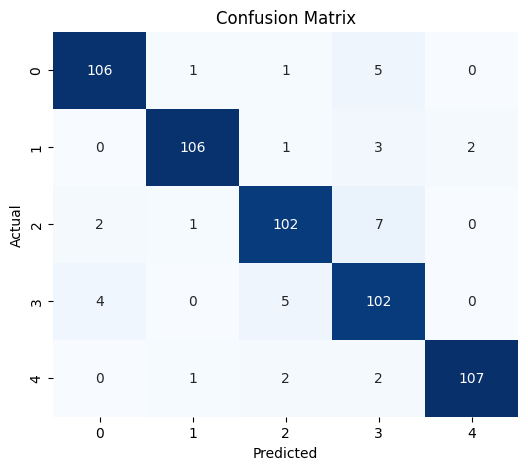

In [19]:

cm = confusion_matrix(np.argmax(Y_test, axis=1), y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



**Loss and accuracy curve**

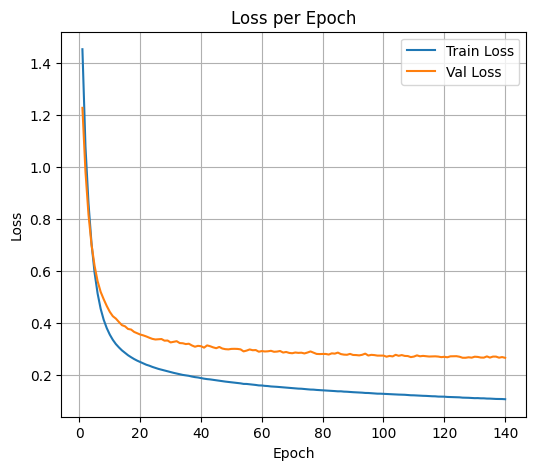

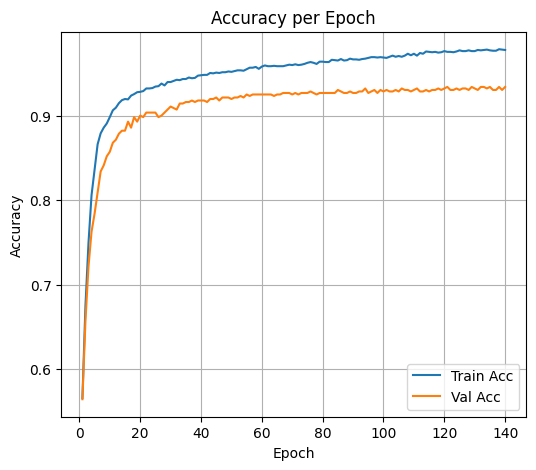

In [20]:

plt.figure(figsize=(6,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss per Epoch'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, epochs+1), val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy per Epoch'); plt.legend(); plt.grid(True)
plt.show()

**ROC curve**

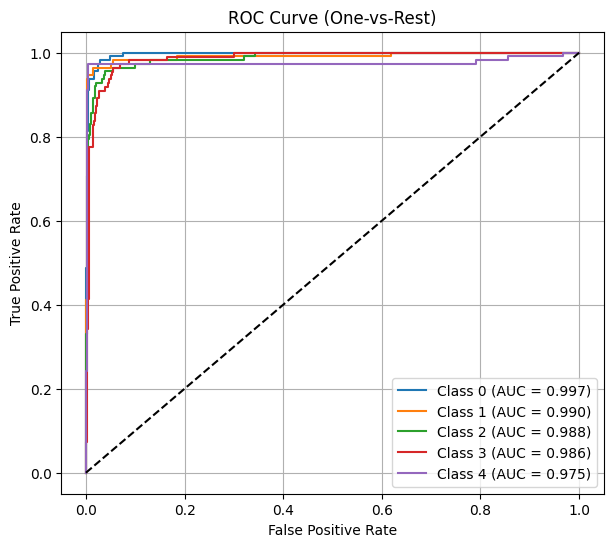

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_true = np.argmax(Y_test, axis=1)
y_test_pred_probs = model.forward(X_test)[1][-1]
y_test_bin = label_binarize(y_test_true, classes=[0,1,2,3,4])


fpr, tpr, roc_auc = {}, {}, {}
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(7,6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Conclusion**

The multi‑class neural network reached 93.39% test accuracy, with strong precision and recall across most classes. Key challenges included debugging backpropagation and stabilizing training with proper initialization, which highlighted the importance of careful design choices. Future improvements could involve deeper architectures, regularization, or advanced optimizers to further boost performance and generalization.
